## Configuration

Set the model, grid, variable, and frame rate for the movie. These parameters can be overridden when running via papermill.


Set the model, grid, variable, and frame rate for the movie. These parameters can be overridden when running via papermill.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
from glob import glob
from subprocess import check_call, CalledProcessError

import numpy as np

import matplotlib.pyplot as plt

import cson_forge


Load the model grid from the blueprint's grid YAML file. The grid provides coordinate information (lon_rho, lat_rho) and masking for proper visualization.


Query the blueprint catalog to find the run blueprint matching the specified model and grid. This provides the path to the simulation output directory.


Find all model output files matching the pattern. These files contain the time-series data for the variable of interest.


Load the model grid from the blueprint's grid YAML file. The grid provides coordinate information (lon_rho, lat_rho) and masking for proper visualization.

In [3]:
df = cson_forge.catalog.blueprint.load(stage="run")
df = df.loc[(df.grid_name == grid_name) & (df.model_name == model_name)]

if df.empty:
    raise ValueError(
        f"No blueprint found: model_name='{model_name}'; grid_name='{grid_name}' "
        f"at stage='run'"
    )

df

,model_name,grid_name,blueprint_name,description,start_time,end_time,blueprint_path,grid_yaml_path,stage
0,cson_roms-marbl_v0.1,ccs-12km,cson_roms-marbl_v0.1_ccs-12km,California Current System,2024-01-01T00:00:00,2024-01-02T00:00:00,/Users/mclong/codes/cson-forge/cson_forge/blue...,/Users/mclong/codes/cson-forge/cson_forge/blue...,run



Load visualization configuration (colormaps, color ranges, projection settings) from the settings YAML file. These settings are domain and variable-specific.

## Get Blueprint Path

Extract the blueprint path from the catalog results. This will be used to locate the simulation directory and grid file.


Find all model output files matching the pattern. These files contain the time-series data for the variable of interest.

In [4]:
blueprint_path = df.blueprint_path.iloc[0]
casename = blueprint_path.stem.replace("B_", "") # get less janky
simulation_dir = Path(cson_forge.config.paths.scratch / casename)

print(f"Blueprint path: {blueprint_path}")
print(f"Simulation directory: {simulation_dir}")

Blueprint path: /Users/mclong/codes/cson-forge/cson_forge/blueprints/cson_roms-marbl_v0.1_ccs-12km/B_cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102.yml
Simulation directory: /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102



Load visualization configuration (colormaps, color ranges, projection settings) from the settings YAML file. These settings are domain and variable-specific.


Find all model output files matching the pattern. These files contain the time-series data for the variable of interest.


If `use_dask_cluster` is enabled, start a Dask cluster for parallel frame generation. This significantly speeds up processing for large datasets with many time steps.

Reading grid file:
 /Users/mclong/codes/cson-forge/cson_forge/blueprints/cson_roms-marbl_v0.1_ccs-12km/_grid.yml


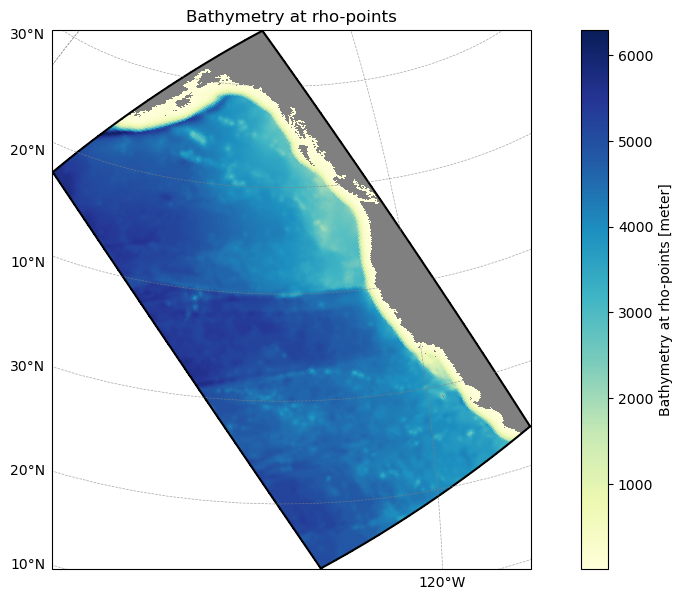

In [5]:
domain_name = f"{model_name}_{grid_name}"

grid_yaml = Path(df.grid_yaml_path.iloc[0])
print("Reading grid file:\n", grid_yaml)

grid_obj = cson_forge.parsers.load_roms_tools_object(grid_yaml)
grid = grid_obj.ds
grid_obj.plot();


If `use_dask_cluster` is enabled, start a Dask cluster for parallel frame generation. This significantly speeds up processing for large datasets with many time steps.

In [6]:
# TODO: make this less janky
pattern = "output_bgc_dia.*"
files = glob(str(simulation_dir / "output" / "joined_output" / pattern))
print(f"Found {len(files)} files matching pattern '{pattern}'")
if files:
    print(f"First file: {Path(files[0]).name}")
    if len(files) > 1:
        print(f"Last file: {Path(files[-1]).name}")
        print(f"All files: {[Path(f).name for f in sorted(files)]}")
else:
    print("No files found!")

Found 1 files matching pattern 'output_bgc_dia.*'
First file: output_bgc_dia.20120101000000.0.nc



Assemble the PNG frames into an MP4 movie using ffmpeg:

- **Input**: Sequentially numbered PNG frames (starting from 0001.png)
- **Output**: MP4 video file with H.264 encoding
- **Settings**: Frame rate, resolution scaling, and fast-start flag for web playback

The movie is saved to the visualization output directory.

## Generate Frames

Generate individual PNG frames for each time step:

- **Load data**: Read model output files and extract the variable
- **Handle grid inconsistencies**: Subset grid if dataset dimensions don't match
- **Plot frames**: Create cartographic plots with proper projection, colormap, and masking
- **Save frames**: Write PNG files numbered sequentially (0001.png, 0002.png, ...)

Frames are generated in parallel using Dask when a cluster is available.

### Data Loading Function

The `load_data` function handles reading model output files and extracting the variable of interest. It:

- Opens NetCDF files using xarray
- Extracts the specified variable
- Handles grid dimension mismatches by subsetting the grid if needed
- Applies land masking using the grid's mask_rho
- Returns the data array with proper coordinates

In [8]:
mmolm2s_to_molm2yr = 1e-3 * 86400.0 * 365.0


def load_data(file, varname):
    """
    Load a variable from a NetCDF file and apply grid masking.
    
    Opens a NetCDF file, extracts the specified variable, applies the grid mask
    to mask out land points, and converts time coordinates to datetime objects.
    Special handling is applied for FG_CO2 to convert units from mmol m^-2 s^-1
    to mol m^-2 yr^-1 and flip the sign.
    
    Parameters
    ----------
    file : str or Path
        Path to the NetCDF file to load.
    varname : str
        Name of the variable to extract from the dataset.
        
    Returns
    -------
    xarray.DataArray
        DataArray containing the variable data with:
        - Grid mask applied (land points masked)
        - Time coordinates converted to datetime objects
        - For FG_CO2: units converted to mol m^-2 yr^-1 and sign flipped
    """
    with xr.open_dataset(file) as ds:
        da = ds[varname]
        # Check if grid dimensions match dataset dimensions
        try:
            da = da.where(grid.mask_rho)
            grid_loc = grid
        except (ValueError, KeyError, IndexError):
            # Grid dimensions don't match - subset grid to match dataset
            print("grid inconsistent with dataset - subsetting grid to match dataset dimensions")
            grid_subset = grid.isel(xi_rho=slice(0, len(da.xi_rho)), eta_rho=slice(0, len(da.eta_rho)))
            da = da.where(grid_subset.mask_rho)
            grid_loc = grid_subset

        assert ds.ocean_time.long_name == "Time since 2000/01/01", "inconsistent time units"
        time = cftime.num2date(ds.ocean_time, units="seconds since 2000-01-01", calendar="standard")
        
        if varname == "FG_CO2":
            da *= mmolm2s_to_molm2yr * -1.0
            da.attrs["units"] = "mol m$^{-2}$ yr$^{-1}$"
        elif varname == "DIC_SRF":
            da = da.isel(s_rho=-1)
            da.attrs["units"] = "mmol m$^{-3}$"
        elif varname == "ALK_SRF":
            da = da.isel(s_rho=-1)
            da.attrs["units"] = "mmol m$^{-3}$"

        return da.assign_coords(time=time, lat_rho=grid_loc.lat_rho, lon_rho=grid_loc.lon_rho)

da_test = load_data(files[-1], varname)
da_test

grid inconsistent with dataset - subsetting grid to match dataset dimensions


<xarray.DataArray 'pCO2SURF' (time: 2, eta_rho: 4, xi_rho: 8)> Size: 256B
array([[[  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
           0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         313.03754, 309.26532,   0.     ],
        [  0.     ,   0.     ,   0.     , 338.44168, 364.99918,
         381.17438, 366.95822,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
           0.     ,   0.     ,   0.     ]],

       [[  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
           0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         320.51703, 317.62775,   0.     ],
        [  0.     ,   0.     ,   0.     , 344.8539 , 367.78467,
         380.2565 , 368.54013,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
           0.     ,   0.     ,   0.     ]]], dtype=float32)
Coordinates:
    lat_rho  (eta_rho, xi_rho) float64 256B 13.18 13.23 13.28 ... 13.77 13.82
    lon_rho  (eta_rho, xi_rho) float64 256B 228.0 228.1 228.2 ... 228.4 228.5
  * time     (time) object 16B 2012-01-01 00:00:00 2012-01-02 00:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  surface pCO2
    units:      ppmv

### Plotting Function

The `plot_frame` function creates a single frame of the movie:

- **Projection**: Uses cartographic projection from settings (e.g., Lambert Conformal)
- **Colormap**: Converts colormap string to matplotlib colormap object
- **Color scale**: Sets levels and normalization from visualization settings
- **Features**: Adds coastlines, land, and ocean masks
- **Title**: Includes variable name and timestamp
- **Output**: Saves frame as PNG file with sequential numbering

The function handles both cmocean and matplotlib colormaps automatically.


Assemble the PNG frames into an MP4 movie using ffmpeg:

- **Input**: Sequentially numbered PNG frames (starting from 0001.png)
- **Output**: MP4 video file with H.264 encoding
- **Settings**: Frame rate, resolution scaling, and fast-start flag for web playback

The movie is saved to the visualization output directory.

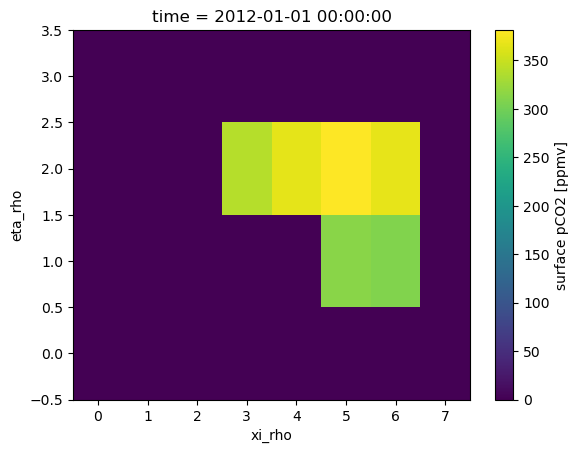

In [9]:
da_test.isel(time=0).plot();

## Load Visualization Settings

Load visualization configuration (colormaps, color ranges, projection settings) from the settings YAML file. These settings are domain and variable-specific.

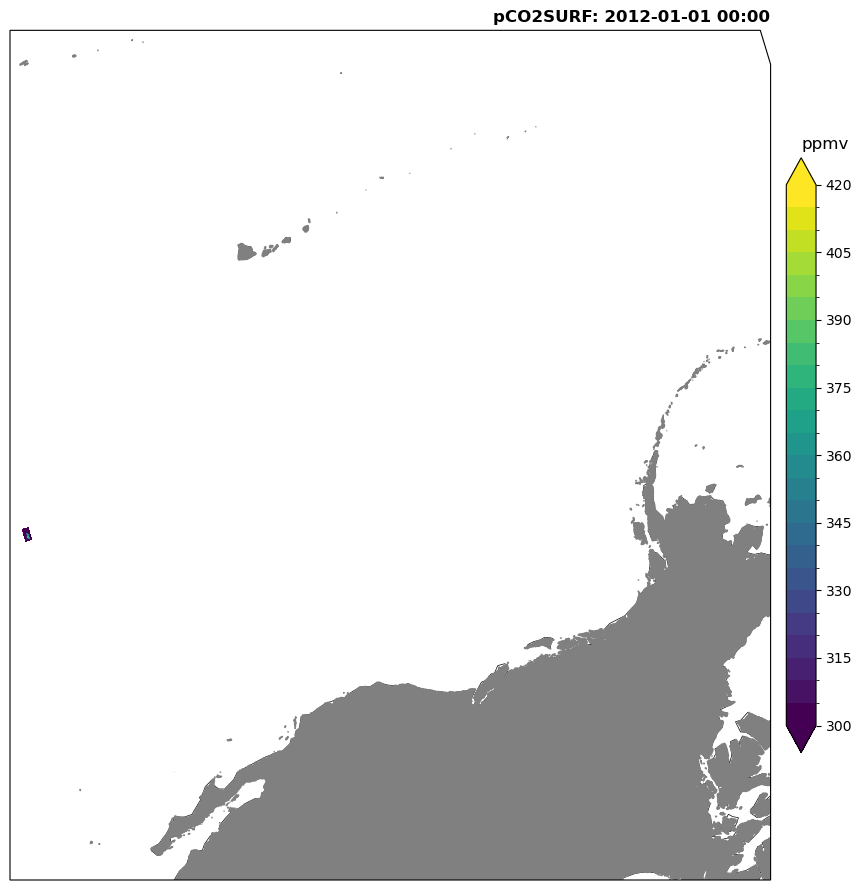

In [10]:
viz_data = cson_forge.parsers.load_visualization_settings("../settings.yml")
viz_data_grid = viz_data.domains[grid_name]
viz_data_var = viz_data.variables[varname]


def plot_frame(da_loc, varname, time_level_movie=None, diro=None):
    """Make a single frame of a movie of FG_CO2"""

    if viz_data_grid.projection.type == "LambertConformal":
        prj = ccrs.LambertConformal(**viz_data_grid.projection.kwargs)  
    
    else:
        # pick a reasonable default
        prj = ccrs.PlateCarree()
    
    levels = np.arange(viz_data_var.cmin, viz_data_var.cmax, viz_data_var.dc)

    fig, ax = plt.subplots(
        figsize=(12, 12),
        facecolor="w",
        subplot_kw=dict(projection=prj),
    )
    
    ax.set_extent([grid.lon_rho.min(), grid.lon_rho.max(), grid.lat_rho.min(), grid.lat_rho.max()])
    ax.coastlines(linewidth=0.5)
    
    # Convert cmap string to matplotlib colormap object
    cmap_name = viz_data_var.cmap
    if hasattr(cmocean.cm, cmap_name):
        cmap = getattr(cmocean.cm, cmap_name)
    elif hasattr(plt.cm, cmap_name):
        cmap = getattr(plt.cm, cmap_name)
    else:
        cmap = plt.get_cmap(cmap_name)

    try:
        pc = ax.pcolormesh(
            da_loc.lon_rho,
            da_loc.lat_rho,
            da_loc,
            cmap=cmap,
            norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
            transform=ccrs.PlateCarree(),
        )
        cb = fig.colorbar(pc, shrink=0.7, extend="both", pad=0.01)
        cb.ax.set_title(da_loc.units, y=1.05, color="k", ha="left")
    except:
        print("error plotting pcolormesh")
        pass

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            "physical", "land", "10m", edgecolor="face", facecolor="grey"
        )
    )    
    ax.add_feature(cartopy.feature.OCEAN, facecolor="w", zorder=0)  # optional ocean mask
   
   
    ax.set_title(
        varname + ": " + da_loc.time.values.item().strftime("%Y-%m-%d %H:%M"),
        loc="right",
        fontweight="bold",
        color="k",
    )

    fig_size = (16, 9)
    fig.set_size_inches(fig_size)
    fig.tight_layout()

    if diro is not None:
        fig.savefig(f"{diro}/{time_level_movie:04d}.png", dpi=300, transparent=True)
        plt.close()

plot_frame(da_test.isel(time=0), varname)

## Setup Dask Cluster (Optional)

If `use_dask_cluster` is enabled, start a Dask cluster for parallel frame generation. This significantly speeds up processing for large datasets with many time steps.

### Plotting Function

The `plot_frame` function creates a single frame of the movie:

- **Projection**: Uses cartographic projection from settings (e.g., Lambert Conformal)
- **Colormap**: Converts colormap string to matplotlib colormap object
- **Color scale**: Sets levels and normalization from visualization settings
- **Features**: Adds coastlines, land, and ocean masks
- **Title**: Includes variable name and timestamp
- **Output**: Saves frame as PNG file with sequential numbering

The function handles both cmocean and matplotlib colormaps automatically.

## Generate Frames

Generate individual PNG frames for each time step:

- **Load data**: Read model output files and extract the variable
- **Handle grid inconsistencies**: Subset grid if dataset dimensions don't match
- **Plot frames**: Create cartographic plots with proper projection, colormap, and masking
- **Save frames**: Write PNG files numbered sequentially (0001.png, 0002.png, ...)

Frames are generated in parallel using Dask when a cluster is available.

In [11]:
cluster = cson_forge.compute.dask_cluster(**dask_cluster_kwargs)
cluster

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Local cluster running at http://127.0.0.1:8787/status


## Create Movie

Assemble the PNG frames into an MP4 movie using ffmpeg:

- **Input**: Sequentially numbered PNG frames (starting from 0001.png)
- **Output**: MP4 video file with H.264 encoding
- **Settings**: Frame rate, resolution scaling, and fast-start flag for web playback

The movie is saved to the visualization output directory.

In [12]:
%%time
diro = Path(f"{cson_forge.config.paths.scratch}/{casename}/visualization/movie-maker/{varname}/png")   
if diro.exists():
    import shutil
    shutil.rmtree(diro)
diro.mkdir(parents=True, exist_ok=True)

output_mp4_path = Path(f"{cson_forge.config.paths.scratch}/{casename}/visualization/movie-maker/{varname}")

print(f"Output directory for {varname} frames:\n {diro}")
print(f"Output {varname} movie:\n {output_mp4_path}")


@dask.delayed
def plot_frame_delayed(da_loc, varname, time_level_movie, diro):
    return plot_frame(da_loc, varname, time_level_movie, diro)

i_frame = 0
for f in files:
    da = load_data(f, varname)

    del_objs = []
    for i in range(da.sizes["time"]):
        del_objs.append(plot_frame_delayed(da.isel(time=i), varname, i_frame, diro))
        i_frame += 1  
    
    computed_objs = dask.compute(*del_objs)

Output directory for pCO2SURF frames:
 /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102/visualization/movie-maker/pCO2SURF/png
Output pCO2SURF movie:
 /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102/visualization/movie-maker/pCO2SURF
grid inconsistent with dataset - subsetting grid to match dataset dimensions


/Users/mclong/.local/share/mamba/envs/cson-forge-v0/lib/python3.13/site-packages/distributed/client.py:3375: UserWarning: Sending large graph of size 10.20 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 582 ms, sys: 170 ms, total: 752 ms
Wall time: 21 s


In [13]:
cluster.shutdown()

In [14]:
ffmpeg_cmd = f"ffmpeg -y -loglevel warning -start_number 1 -r {fps} -i {diro}/%04d.png"
ffmpeg_cmd += " -c:v libx264 -pix_fmt yuv420p "
ffmpeg_cmd += " -vf 'scale=1440:trunc(ow/a/2)*2' -movflags faststart "
ffmpeg_cmd += f"{output_mp4_path}.mp4"

try:
    out = check_call(ffmpeg_cmd, shell=True)
    print(f"Movie successfully created: {output_mp4_path}")
except CalledProcessError as e:
    raise RuntimeError(
        f"ffmpeg failed with exit code {e.returncode}.\n"
        f"Command: {ffmpeg_cmd}\n"
        f"Make sure PNG frames exist in {diro} and ffmpeg is installed correctly."
    ) from e

Movie successfully created: /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102/visualization/movie-maker/pCO2SURF
